In [1]:
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats
import itertools
import logging
import os
import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch
import torch.optim as optim
import torch.nn.functional as F
from argparse import ArgumentParser
from torch.distributions import MultivariateNormal
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import RobustScaler, QuantileTransformer, StandardScaler
from sklearn.neighbors import NearestNeighbors

from nf.flows import *
from nf.models import NormalizingFlowModel
import matplotlib.pyplot as plt

In [3]:
! ls ../data/data_calibsample

kaon2_+_down_2016_.csv	muon_+_down_2016_.csv	pion_+_down_2016_.csv
kaon2_+_up_2016_.csv	muon_+_up_2016_.csv	pion_+_up_2016_.csv
kaon2_-_down_2016_.csv	muon_-_down_2016_.csv	pion_-_down_2016_.csv
kaon2_-_up_2016_.csv	muon_-_up_2016_.csv	pion_-_up_2016_.csv
kaon_+_down_2016_.csv	pion2_+_down_2016_.csv	proton_+_down_2016_.csv
kaon_+_up_2016_.csv	pion2_+_up_2016_.csv	proton_+_up_2016_.csv
kaon_-_down_2016_.csv	pion2_-_down_2016_.csv	proton_-_down_2016_.csv
kaon_-_up_2016_.csv	pion2_-_up_2016_.csv	proton_-_up_2016_.csv


In [4]:
device = 'cuda'
batch_size = 8192
data_dir = '../data/data_calibsample'
particle = 'muon'
weight_filed = 'probe_sWeight'
features = ['Brunel_P', 'Brunel_ETA', 'nTracks_Brunel']
dlls = ['RichDLLp', 'RichDLLe', 'RichDLLmu', 'RichDLLk', 'RichDLLbt']
fields = [weight_filed] + features + dlls

In [5]:
data = pd.concat([
    pd.read_csv(os.path.join(data_dir, f), sep='\t')[fields]
    for f in os.listdir(data_dir) if particle in f
]).sample(frac=1)
data.head()

,probe_sWeight,Brunel_P,Brunel_ETA,nTracks_Brunel,RichDLLp,RichDLLe,RichDLLmu,RichDLLk,RichDLLbt
237156,-0.304468,42012.2,2.12333,157,-64.9162,-2.70496,-1.121880,15.3277,-77.0490
180740,-0.390798,15917.6,2.61721,105,26.7672,1.13756,0.788403,48.1063,26.7672
223483,1.009760,11540.2,2.60932,161,-30.0137,-1.60877,-0.465560,-34.1912,-30.0137
68998,1.265420,29935.7,3.39514,101,-40.2822,-1.05149,-0.387154,-41.5792,-32.2433
54171,1.191620,12742.3,2.18282,117,-19.0347,15.54300,10.642700,-30.5516,-19.0347


In [6]:
data = data[data.RichDLLe > -998]
data = data[data.RichDLLp != 0.0]
data.shape

(1984209, 9)

In [7]:
X, Y, weights = data[features].values.astype(np.float32), data[dlls].values.astype(np.float32), data[weight_filed].values.astype(np.float32)
train_size = data.shape[0] * 7 // 10

X_train_, Y_train_, w_train = X[: train_size], Y[: train_size], weights[: train_size]
X_val_, Y_val_, w_val = X[train_size :], Y[train_size :], weights[train_size :]
X_train_.shape, X_val_.shape

((1388946, 3), (595263, 3))

In [9]:
class DataPreprocessor:
    def __init__(self):
        self.q_scaler = QuantileTransformer(
            output_distribution="normal",
            n_quantiles=100000,
            subsample=int(1e10)
        )

    def fit(self, X, Y):
        self.q_scaler.fit(Y)
        return self
    
    def transform(self, X, Y):
        return np.log(X + 1), self.q_scaler.transform(Y)
    
    def inverse_transform(self, X, Y):
        return np.exp(X) - 1, self.q_scaler.inverse_transform(Y)

In [10]:
preprocessor = DataPreprocessor().fit(X_train_, Y_train_)
X_train, Y_train = preprocessor.transform(X_train_, Y_train_)
X_val, Y_val = preprocessor.transform(X_val_, Y_val_)

In [11]:
def get_data_generator(X, Y, batch_size):
    X = torch.from_numpy(X).to(device)
    Y = torch.from_numpy(Y).to(device)
    assert(len(X) == len(Y))
    while True:
        for i in range(0, len(X), batch_size):
            yield (X[i: i + batch_size], Y[i: i + batch_size])

data_gen = get_data_generator(X_train, Y_train.astype(np.float32), batch_size)

In [12]:
from scipy import special

def bin_log_probs(arr, vals, bins):
    arr_bins = np.cumsum(arr.reshape(-1, 1) > bins, axis=1)[:, -1] - 1
    bin_range = np.arange(bins.shape[0] - 1)
    bin_vals = (arr_bins == bin_range.reshape(-1, 1)) * vals
    
    sum_bin_vals = special.logsumexp(np.where(bin_vals != 0.0, bin_vals, -np.inf), axis=1)
    
    bin_vals = np.exp(sum_bin_vals) / (np.sum(bin_vals != 0.0, axis=1) + 0.0001)
    new_bins = (bins[:-1] + bins[1:]) / 2
    
    return new_bins, bin_vals

In [13]:
class ConditionalNormalizingFlowModel(nn.Module):

    def __init__(self, dim, condition_dim, prior, flows):
        super().__init__()
        self.dim = dim
        self.condition_dim = condition_dim
        self.prior = prior
        self.flows = nn.ModuleList(flows)

    def forward(self, x, condition):
        m, _ = x.shape
        log_det = torch.zeros(m).to(x.device)
        for flow in self.flows:
            x, ld = flow.forward(x, condition)
            log_det += ld
        z, prior_logprob = x, self.prior.log_prob(x.to('cpu')).to(x.device)
        return z, prior_logprob, log_det

    def backward(self, z, condition):
        m, _ = z.shape
        log_det = torch.zeros(m).to(z.device)
        for flow in self.flows[::-1]:
            z, ld = flow.backward(z, condition)
            log_det += ld
        x = z
        return x, log_det

    def sample(self, n_samples):
        z = self.prior.sample((n_samples,self.dim))
        if z.dim() != 2: z = self.prior.sample((n_samples,))
        x, _ = self.backward(z)
        return x

In [14]:
class ConditionalMAF(nn.Module):
    def __init__(self, dim, cond_dim, hidden_dim = 8, base_network=FCNN):
        super().__init__()
        self.dim = dim
        self.layers = nn.ModuleList()
        self.initial_param = nn.Parameter(torch.Tensor(2))
        for i in range(1, dim):
            self.layers += [base_network(i + cond_dim, 2, hidden_dim)]
        self.reset_parameters()

    def reset_parameters(self):
        init.uniform_(self.initial_param, -math.sqrt(0.5), math.sqrt(0.5))

    def forward(self, x, condition):
        z = torch.zeros_like(x)
        log_det = torch.zeros(z.shape[0]).to(x.device)
        for i in range(self.dim):
            if i == 0:
                mu, alpha = self.initial_param[0], self.initial_param[1]
            else:
                out = self.layers[i - 1](torch.cat([x[:, :i], condition], axis=1))
                mu, alpha = out[:, 0], out[:, 1]
            z[:, i] = (x[:, i] - mu) / torch.exp(alpha)
            log_det -= alpha
        return z.flip(dims=(1,)), log_det

    def backward(self, z, condition):
        x = torch.zeros_like(z)
        log_det = torch.zeros(z.shape[0]).to(z.device)
        z = z.flip(dims=(1,))
        for i in range(self.dim):
            if i == 0:
                mu, alpha = self.initial_param[0], self.initial_param[1]
            else:
                out = self.layers[i - 1](torch.cat([x[:, :i], condition], axis=1))
                mu, alpha = out[:, 0], out[:, 1]
            x[:, i] = mu + torch.exp(alpha) * z[:, i]
            log_det += alpha
        return x, log_det

In [15]:
dim, cond_dim = len(dlls), len(features)
flows = [
    ConditionalMAF(dim=dim, cond_dim=cond_dim, hidden_dim=32).to(device) for _ in range(4)
]
prior = MultivariateNormal(torch.zeros(dim), torch.eye(dim))
model = ConditionalNormalizingFlowModel(dim, len(features), prior, flows)
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [16]:
# dim, cond_dim = len(dlls), len(features)
# flows = [
#     ConditionalMAF(dim=dim, cond_dim=0, hidden_dim=32).to(device) for _ in range(4)
# ]
# prior = MultivariateNormal(torch.zeros(dim), torch.eye(dim))
# model = ConditionalNormalizingFlowModel(dim, len(features), prior, flows)
# optimizer = optim.Adam(model.parameters(), lr=0.005)

In [17]:
metrics = []

In [18]:
neigh = NearestNeighbors(1).fit(Y_val_)

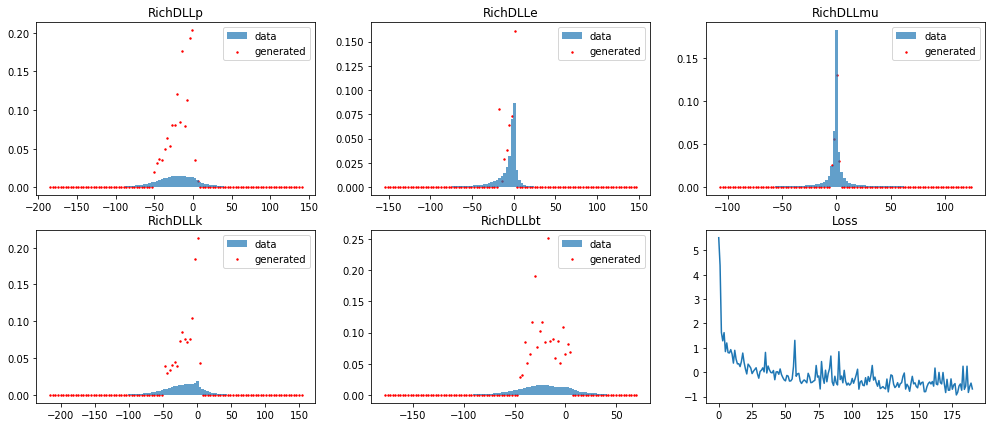

KeyboardInterrupt: 

In [28]:
epoches = 1000

for epoch in range(len(metrics), epoches):
    model.train()
    for step, (cond_x, batch_x) in zip(range(len(X_train) // 8192), data_gen):
        optimizer.zero_grad()
        z, logp_z, log_det = model(batch_x, cond_x)
        logp_x = logp_z + log_det
        loss = -torch.mean(logp_x)
        loss.backward()
        optimizer.step()
    metrics.append(loss.mean().detach())

    if epoch % 10 == 0:
        model.eval()
        with torch.no_grad():
            Y_test = np.random.uniform(-1, 1, (100000, dim)).astype('float32')
            Y_test_ = preprocessor.q_scaler.inverse_transform(Y_test)
            idxs = neigh.kneighbors(Y_test_, 1, return_distance=False)[:, 0]
            X_test = X_val[idxs]

            z, logp_z, log_det = model(
                torch.from_numpy(Y_test).to(device),
                torch.from_numpy(X_test).to(device)
            )
            log_probs = logp_z + log_det
            log_probs = log_probs.cpu().numpy()

            clear_output(False)
            fig, axs = plt.subplots(2, 3, figsize=(17, 7))
            for i in range(dim):
                _, bins, _ = axs[i // 3, i % 3].hist(Y_val_[:, i], 100, label="data", density=True, alpha=0.7)
                axs[i // 3, i % 3].scatter(*bin_log_probs(Y_test_[:, i], log_probs, bins), label="generated", c='red', s=2)
                axs[i // 3, i % 3].set_title(dlls[i])
                axs[i // 3, i % 3].legend()
            axs[1, 2].plot(np.arange(len(metrics)), metrics)
            axs[1, 2].set_title('Loss')
        plt.show()

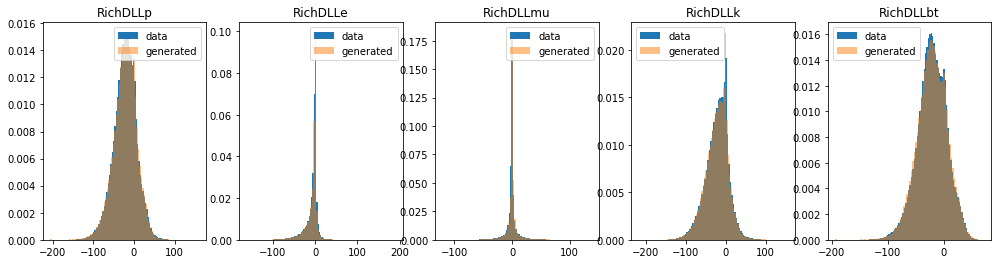

In [30]:
model.eval()
with torch.no_grad():
    Z_test = np.random.normal(0, 1, (len(X_val), dim)).astype('float32')
    Y_pred, log_det = model.backward(
        torch.from_numpy(Z_test).to(device),
        torch.from_numpy(X_val).to(device)
    )
    Y_pred = Y_pred.cpu().numpy()
    Y_pred = preprocessor.q_scaler.inverse_transform(Y_pred)
    
    fig, axs = plt.subplots(1, dim, figsize=(17, 4))
    for i in range(dim):
        axs[i].hist(Y_val_[:, i], 100, label="data", density=True)
        axs[i].hist(Y_pred[:, i], 100, label="generated", density=True, alpha=0.5)
        axs[i].legend()
        axs[i].set_title(dlls[i])

In [44]:
d1 = pd.DataFrame(np.hstack([Y_val_, X_val_, w_val.reshape(-1, 1)]), columns=dlls + features + [weight_filed])
d2 = pd.DataFrame(np.hstack([Y_pred, X_val_, w_val.reshape(-1, 1)]), columns=dlls + features + [weight_filed])
d1['IsGenerated'] = False
d2['IsGenerated'] = True
d2.head()

,RichDLLp,RichDLLe,RichDLLmu,RichDLLk,RichDLLbt,Brunel_P,Brunel_ETA,nTracks_Brunel,probe_sWeight,IsGenerated
0,-18.122854,-2.991262,53.325523,-17.917250,-17.981802,3626.739990,2.49773,161.0,-0.383746,True
1,-7.366815,-7.388227,-1.891052,-8.164062,-7.655575,14362.400391,4.31870,201.0,1.188340,True
2,-3.414302,-0.126401,-0.044424,0.567252,-17.815327,131459.000000,4.36102,257.0,-0.344495,True
3,-53.596149,-12.931388,-1.732594,-52.679409,-52.958427,14809.500000,3.63145,384.0,-0.290193,True
4,-13.355317,-0.066015,-0.004456,-0.536480,-8.835152,126590.000000,3.78532,341.0,-0.228329,True


In [37]:
def plot_joint_dll_distributions(data, dlls):
    fig, axs = plt.subplots(len(dlls), len(dlls), figsize=(17, 15))#, sharex=True, sharey=True)

    for j, dll1 in enumerate(dlls):
        for i, dll2 in enumerate(dlls):
            q1_1, q1_99 = data[dll1].quantile(0.03), data[dll1].quantile(0.97)
            q2_1, q2_99 = data[dll2].quantile(0.03), data[dll2].quantile(0.97)

            if i == j:
                arr = data[[dll1]].query(f'{q1_1} < {dll1} < {q1_99}')
                axs[i, i].hist(arr[dll1], 100)
                axs[i, i].set_title(dll1)
            else:
                arr = data[[dll1, dll2]] \
                    .query(f'{q1_1} < {dll1} < {q1_99}') \
                    .query(f'{q2_1} < {dll2} < {q2_99}')

                axs[i, j].hist2d(arr[dll1], arr[dll2], (100, 100, ))
                m1, m2 = max(q1_1, q2_1), min(q1_99, q2_99)
                axs[i, j].plot(np.arange(m1, m2, 1), np.arange(m1, m2, 1), c='red')
                axs[i, j].set_title(dll1 + ' ' + dll2)

## Original data distributions

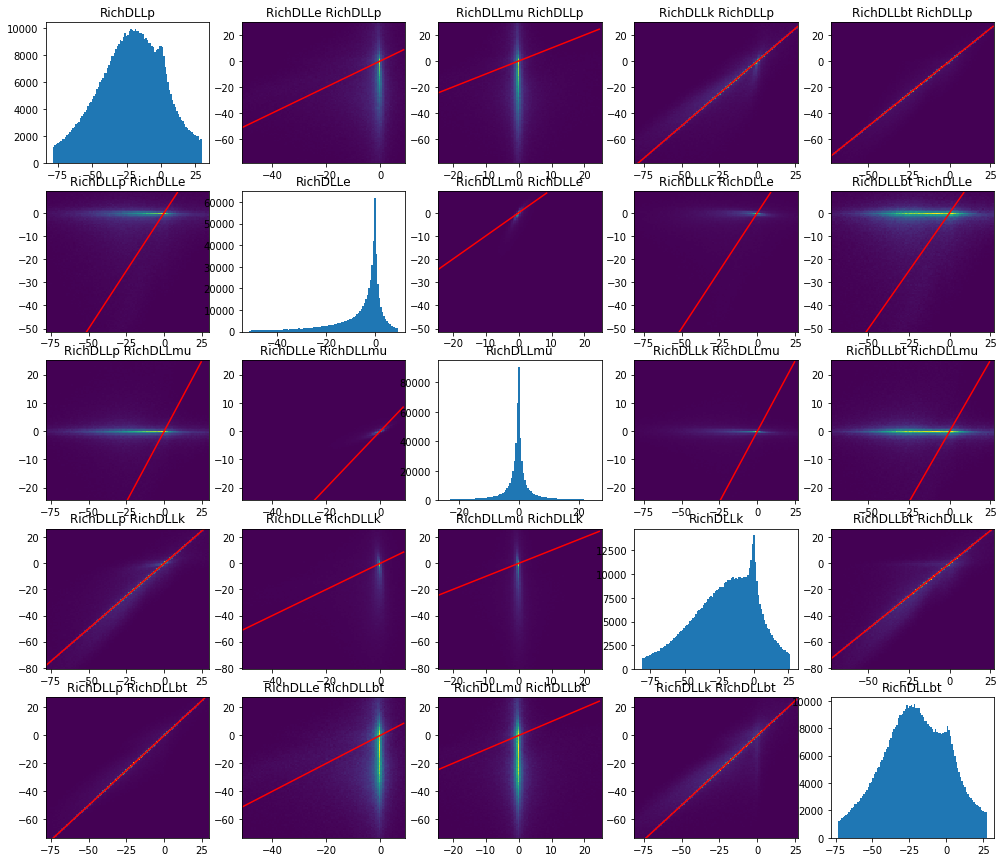

In [35]:
plot_joint_dll_distributions(d1, dlls)

## Generated data distributions

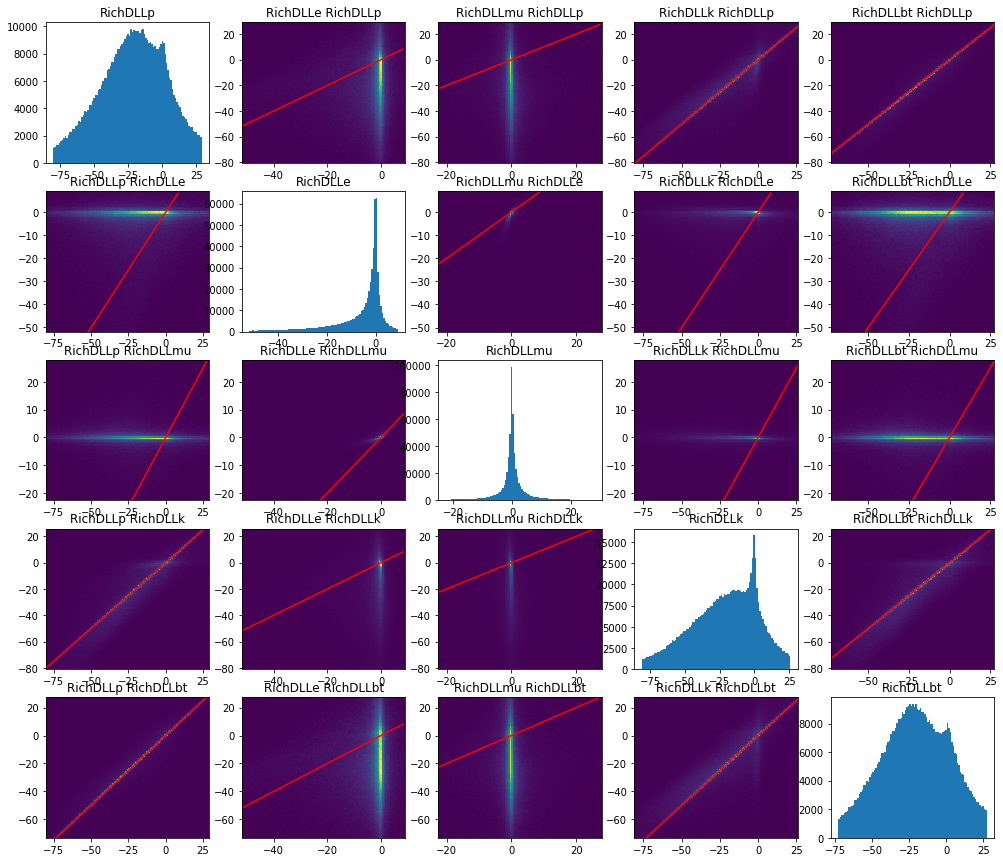

In [36]:
plot_joint_dll_distributions(d2, dlls)

In [38]:
def plot_joint_cond_dll_distributions(data, dll, features):
    fig, axs = plt.subplots(len(dlls) + 1, len(features), figsize=(17, 17))

    for j, f in enumerate(features):
        for i, dll in enumerate([None] + dlls):
            q2_1, q2_99 = data[f].quantile(0.03), data[f].quantile(0.97)
            if i == 0:
                arr = data[[f]].query(f'{q2_1} < {f} < {q2_99}')
                axs[i, j].hist(arr[f], 500)
                axs[i, j].set_title(f)
            else:
                q1_1, q1_99 = data[dll].quantile(0.03), data[dll].quantile(0.97)        

                arr = data[[dll, f]] \
                    .query(f'{q1_1} < {dll} < {q1_99}') \
                    .query(f'{q2_1} < {f} < {q2_99}')

                axs[i, j].hist2d(arr[f], arr[dll], (100, 100, ))
                axs[i, j].set_title(f + ' ' + dll)

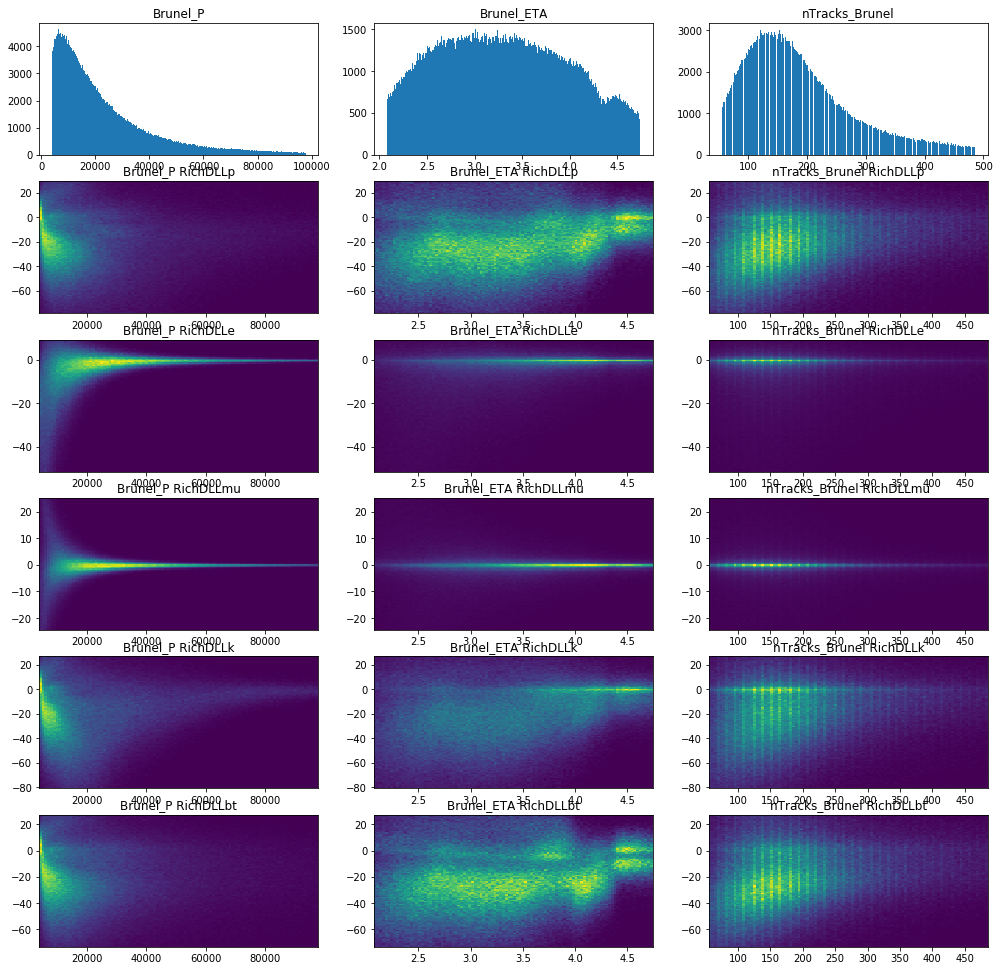

In [40]:
plot_joint_cond_dll_distributions(d1, dlls, features)

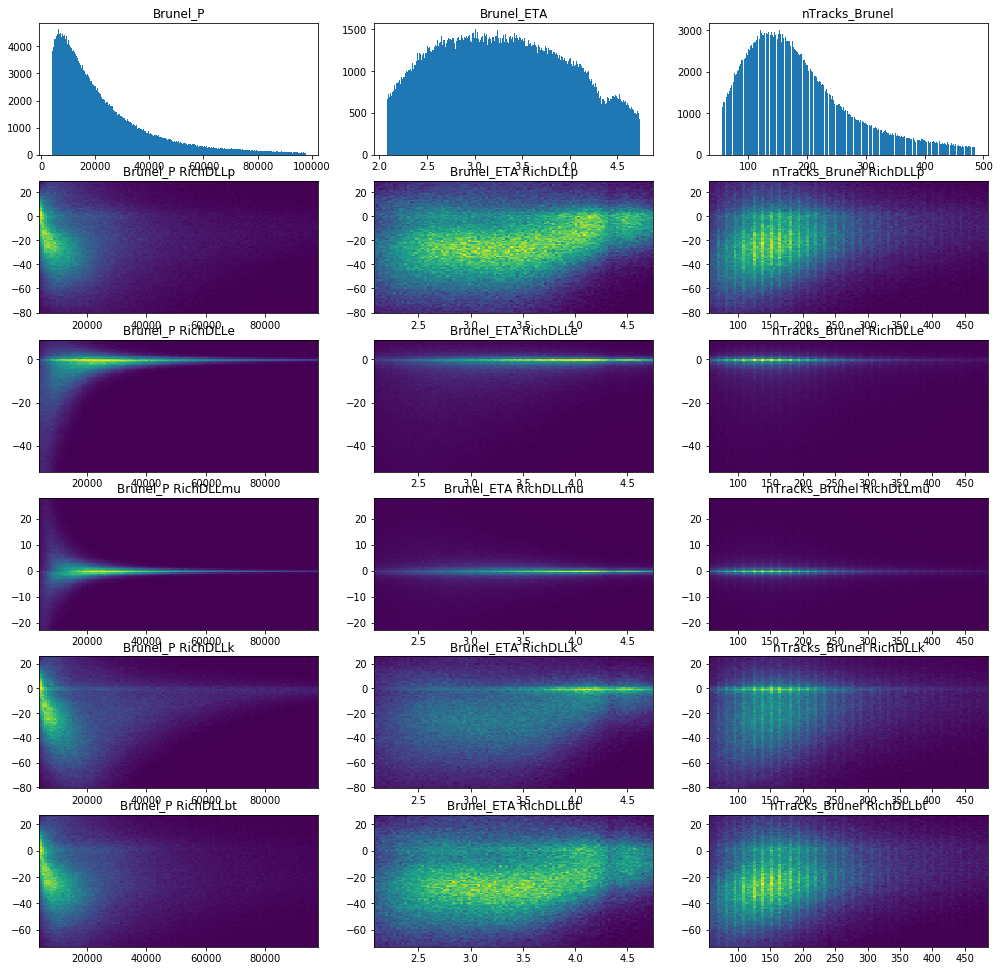

In [41]:
plot_joint_cond_dll_distributions(d2, dlls, features)

In [46]:
classification_ds = pd.concat([d1, d2]).sample(frac=1)
classification_ds.head(10)

,RichDLLp,RichDLLe,RichDLLmu,RichDLLk,RichDLLbt,Brunel_P,Brunel_ETA,nTracks_Brunel,probe_sWeight,IsGenerated
415476,-12.254265,0.596271,3.419883,-12.663358,-10.765984,8857.339844,3.07617,82.0,-0.365283,True
495721,-26.030001,1.696000,0.744558,-32.404499,-13.507100,37001.500000,3.17325,167.0,0.936590,False
242785,-48.433094,1.538785,0.902017,-70.801369,-48.542007,14129.200195,2.82511,124.0,0.160834,True
378559,-55.798576,-2.927332,-0.941420,-36.714844,-37.508289,39048.398438,3.62981,108.0,-0.006882,True
520358,-9.181830,15.941500,12.203600,-14.268900,-9.181830,12392.500000,3.53977,151.0,1.009940,False
259099,-31.864136,-2.105876,-1.192880,-26.635498,-30.724600,31147.800781,3.48295,170.0,-0.386085,True
196455,-46.578602,-8.751970,-2.491190,-72.905800,-47.110199,21375.500000,3.04971,162.0,-0.138937,False
250261,-4.303258,-0.036537,-0.006793,-9.587441,-8.986812,94602.601562,4.99461,137.0,0.632443,True
537922,-77.340599,-34.366100,-8.811100,-77.559196,-77.340599,9190.110352,2.61089,77.0,-0.179056,False
544253,-18.055357,-4.253683,2.977918,-18.474545,-17.698734,12197.700195,3.65664,192.0,1.187040,True


In [47]:
n_cls_train = 7 * classification_ds.shape[0] // 10
cls_train = classification_ds[: n_cls_train]
cls_val = classification_ds[n_cls_train :]
cls_train.shape, cls_val.shape

((833368, 10), (357158, 10))

In [48]:
from catboost import CatBoostClassifier

In [49]:
cb = CatBoostClassifier(iterations=1000, loss_function='Logloss', eval_metric='AUC', use_best_model=True)

In [52]:
cb.fit(
    cls_train[dlls + features].values, cls_train['IsGenerated'].values.astype('int32'),
    eval_set=(cls_val[dlls + features].values, cls_val['IsGenerated'].values.astype('int32'))
)

Learning rate set to 0.158103
0:	test: 0.5450371	best: 0.5450371 (0)	total: 313ms	remaining: 5m 12s
1:	test: 0.5500820	best: 0.5500820 (1)	total: 570ms	remaining: 4m 44s
2:	test: 0.5536602	best: 0.5536602 (2)	total: 764ms	remaining: 4m 13s
3:	test: 0.5555271	best: 0.5555271 (3)	total: 955ms	remaining: 3m 57s
4:	test: 0.5651379	best: 0.5651379 (4)	total: 1.22s	remaining: 4m 2s
5:	test: 0.5667514	best: 0.5667514 (5)	total: 1.45s	remaining: 4m
6:	test: 0.5753696	best: 0.5753696 (6)	total: 1.64s	remaining: 3m 52s
7:	test: 0.5761067	best: 0.5761067 (7)	total: 1.8s	remaining: 3m 42s
8:	test: 0.5784930	best: 0.5784930 (8)	total: 1.99s	remaining: 3m 39s
9:	test: 0.5822449	best: 0.5822449 (9)	total: 2.27s	remaining: 3m 44s
10:	test: 0.5841607	best: 0.5841607 (10)	total: 2.58s	remaining: 3m 51s
11:	test: 0.5867504	best: 0.5867504 (11)	total: 2.75s	remaining: 3m 46s
12:	test: 0.5877155	best: 0.5877155 (12)	total: 2.96s	remaining: 3m 44s
13:	test: 0.5886796	best: 0.5886796 (13)	total: 3.19s	remain

114:	test: 0.6512280	best: 0.6512280 (114)	total: 19.6s	remaining: 2m 30s
115:	test: 0.6513796	best: 0.6513796 (115)	total: 19.7s	remaining: 2m 30s
116:	test: 0.6515718	best: 0.6515718 (116)	total: 19.9s	remaining: 2m 29s
117:	test: 0.6518039	best: 0.6518039 (117)	total: 20s	remaining: 2m 29s
118:	test: 0.6519842	best: 0.6519842 (118)	total: 20.2s	remaining: 2m 29s
119:	test: 0.6522575	best: 0.6522575 (119)	total: 20.3s	remaining: 2m 29s
120:	test: 0.6528096	best: 0.6528096 (120)	total: 20.5s	remaining: 2m 28s
121:	test: 0.6530634	best: 0.6530634 (121)	total: 20.7s	remaining: 2m 28s
122:	test: 0.6533355	best: 0.6533355 (122)	total: 20.8s	remaining: 2m 28s
123:	test: 0.6534141	best: 0.6534141 (123)	total: 21s	remaining: 2m 28s
124:	test: 0.6535900	best: 0.6535900 (124)	total: 21.1s	remaining: 2m 27s
125:	test: 0.6536907	best: 0.6536907 (125)	total: 21.3s	remaining: 2m 27s
126:	test: 0.6538328	best: 0.6538328 (126)	total: 21.4s	remaining: 2m 27s
127:	test: 0.6541058	best: 0.6541058 (127)

226:	test: 0.6825299	best: 0.6825299 (226)	total: 38s	remaining: 2m 9s
227:	test: 0.6831698	best: 0.6831698 (227)	total: 38.2s	remaining: 2m 9s
228:	test: 0.6833346	best: 0.6833346 (228)	total: 38.4s	remaining: 2m 9s
229:	test: 0.6834386	best: 0.6834386 (229)	total: 38.5s	remaining: 2m 8s
230:	test: 0.6837731	best: 0.6837731 (230)	total: 38.7s	remaining: 2m 8s
231:	test: 0.6837752	best: 0.6837752 (231)	total: 38.8s	remaining: 2m 8s
232:	test: 0.6838903	best: 0.6838903 (232)	total: 39s	remaining: 2m 8s
233:	test: 0.6841252	best: 0.6841252 (233)	total: 39.2s	remaining: 2m 8s
234:	test: 0.6841878	best: 0.6841878 (234)	total: 39.3s	remaining: 2m 7s
235:	test: 0.6854936	best: 0.6854936 (235)	total: 39.4s	remaining: 2m 7s
236:	test: 0.6857396	best: 0.6857396 (236)	total: 39.6s	remaining: 2m 7s
237:	test: 0.6860168	best: 0.6860168 (237)	total: 39.7s	remaining: 2m 7s
238:	test: 0.6864193	best: 0.6864193 (238)	total: 39.9s	remaining: 2m 6s
239:	test: 0.6866790	best: 0.6866790 (239)	total: 40s	r

338:	test: 0.7215916	best: 0.7215916 (338)	total: 55.9s	remaining: 1m 48s
339:	test: 0.7218748	best: 0.7218748 (339)	total: 56s	remaining: 1m 48s
340:	test: 0.7219181	best: 0.7219181 (340)	total: 56.2s	remaining: 1m 48s
341:	test: 0.7224949	best: 0.7224949 (341)	total: 56.3s	remaining: 1m 48s
342:	test: 0.7226460	best: 0.7226460 (342)	total: 56.5s	remaining: 1m 48s
343:	test: 0.7227598	best: 0.7227598 (343)	total: 56.6s	remaining: 1m 48s
344:	test: 0.7228296	best: 0.7228296 (344)	total: 56.8s	remaining: 1m 47s
345:	test: 0.7234479	best: 0.7234479 (345)	total: 57s	remaining: 1m 47s
346:	test: 0.7240827	best: 0.7240827 (346)	total: 57.1s	remaining: 1m 47s
347:	test: 0.7245578	best: 0.7245578 (347)	total: 57.3s	remaining: 1m 47s
348:	test: 0.7246645	best: 0.7246645 (348)	total: 57.4s	remaining: 1m 47s
349:	test: 0.7247796	best: 0.7247796 (349)	total: 57.6s	remaining: 1m 46s
350:	test: 0.7248252	best: 0.7248252 (350)	total: 57.7s	remaining: 1m 46s
351:	test: 0.7252933	best: 0.7252933 (351)

450:	test: 0.7444202	best: 0.7444202 (450)	total: 1m 13s	remaining: 1m 29s
451:	test: 0.7444589	best: 0.7444589 (451)	total: 1m 13s	remaining: 1m 29s
452:	test: 0.7445337	best: 0.7445337 (452)	total: 1m 13s	remaining: 1m 28s
453:	test: 0.7446136	best: 0.7446136 (453)	total: 1m 13s	remaining: 1m 28s
454:	test: 0.7448266	best: 0.7448266 (454)	total: 1m 14s	remaining: 1m 28s
455:	test: 0.7449591	best: 0.7449591 (455)	total: 1m 14s	remaining: 1m 28s
456:	test: 0.7452934	best: 0.7452934 (456)	total: 1m 14s	remaining: 1m 28s
457:	test: 0.7453694	best: 0.7453694 (457)	total: 1m 14s	remaining: 1m 28s
458:	test: 0.7454650	best: 0.7454650 (458)	total: 1m 14s	remaining: 1m 27s
459:	test: 0.7455786	best: 0.7455786 (459)	total: 1m 14s	remaining: 1m 27s
460:	test: 0.7457787	best: 0.7457787 (460)	total: 1m 14s	remaining: 1m 27s
461:	test: 0.7460810	best: 0.7460810 (461)	total: 1m 15s	remaining: 1m 27s
462:	test: 0.7461572	best: 0.7461572 (462)	total: 1m 15s	remaining: 1m 27s
463:	test: 0.7462131	best

561:	test: 0.7586936	best: 0.7586936 (561)	total: 1m 30s	remaining: 1m 10s
562:	test: 0.7587309	best: 0.7587309 (562)	total: 1m 30s	remaining: 1m 10s
563:	test: 0.7589170	best: 0.7589170 (563)	total: 1m 30s	remaining: 1m 10s
564:	test: 0.7589580	best: 0.7589580 (564)	total: 1m 30s	remaining: 1m 10s
565:	test: 0.7589739	best: 0.7589739 (565)	total: 1m 31s	remaining: 1m 9s
566:	test: 0.7591314	best: 0.7591314 (566)	total: 1m 31s	remaining: 1m 9s
567:	test: 0.7594911	best: 0.7594911 (567)	total: 1m 31s	remaining: 1m 9s
568:	test: 0.7595376	best: 0.7595376 (568)	total: 1m 31s	remaining: 1m 9s
569:	test: 0.7598070	best: 0.7598070 (569)	total: 1m 31s	remaining: 1m 9s
570:	test: 0.7599229	best: 0.7599229 (570)	total: 1m 31s	remaining: 1m 9s
571:	test: 0.7599773	best: 0.7599773 (571)	total: 1m 32s	remaining: 1m 8s
572:	test: 0.7603123	best: 0.7603123 (572)	total: 1m 32s	remaining: 1m 8s
573:	test: 0.7602921	best: 0.7603123 (572)	total: 1m 32s	remaining: 1m 8s
574:	test: 0.7604139	best: 0.76041

673:	test: 0.7697379	best: 0.7697379 (673)	total: 1m 48s	remaining: 52.3s
674:	test: 0.7700975	best: 0.7700975 (674)	total: 1m 48s	remaining: 52.1s
675:	test: 0.7701382	best: 0.7701382 (675)	total: 1m 48s	remaining: 52s
676:	test: 0.7701601	best: 0.7701601 (676)	total: 1m 48s	remaining: 51.8s
677:	test: 0.7701866	best: 0.7701866 (677)	total: 1m 48s	remaining: 51.7s
678:	test: 0.7701988	best: 0.7701988 (678)	total: 1m 48s	remaining: 51.5s
679:	test: 0.7703497	best: 0.7703497 (679)	total: 1m 49s	remaining: 51.3s
680:	test: 0.7704558	best: 0.7704558 (680)	total: 1m 49s	remaining: 51.2s
681:	test: 0.7705785	best: 0.7705785 (681)	total: 1m 49s	remaining: 51s
682:	test: 0.7706034	best: 0.7706034 (682)	total: 1m 49s	remaining: 50.9s
683:	test: 0.7706344	best: 0.7706344 (683)	total: 1m 49s	remaining: 50.7s
684:	test: 0.7709528	best: 0.7709528 (684)	total: 1m 49s	remaining: 50.5s
685:	test: 0.7709619	best: 0.7709619 (685)	total: 1m 50s	remaining: 50.4s
686:	test: 0.7713171	best: 0.7713171 (686)

785:	test: 0.7811672	best: 0.7811672 (785)	total: 2m 6s	remaining: 34.3s
786:	test: 0.7812098	best: 0.7812098 (786)	total: 2m 6s	remaining: 34.2s
787:	test: 0.7812468	best: 0.7812468 (787)	total: 2m 6s	remaining: 34s
788:	test: 0.7813318	best: 0.7813318 (788)	total: 2m 6s	remaining: 33.9s
789:	test: 0.7814221	best: 0.7814221 (789)	total: 2m 6s	remaining: 33.7s
790:	test: 0.7815805	best: 0.7815805 (790)	total: 2m 6s	remaining: 33.5s
791:	test: 0.7815927	best: 0.7815927 (791)	total: 2m 7s	remaining: 33.4s
792:	test: 0.7816080	best: 0.7816080 (792)	total: 2m 7s	remaining: 33.2s
793:	test: 0.7816271	best: 0.7816271 (793)	total: 2m 7s	remaining: 33s
794:	test: 0.7816218	best: 0.7816271 (793)	total: 2m 7s	remaining: 32.9s
795:	test: 0.7816389	best: 0.7816389 (795)	total: 2m 7s	remaining: 32.7s
796:	test: 0.7816779	best: 0.7816779 (796)	total: 2m 7s	remaining: 32.6s
797:	test: 0.7817466	best: 0.7817466 (797)	total: 2m 7s	remaining: 32.4s
798:	test: 0.7818579	best: 0.7818579 (798)	total: 2m 8s

897:	test: 0.7881199	best: 0.7881199 (897)	total: 2m 25s	remaining: 16.5s
898:	test: 0.7881199	best: 0.7881199 (898)	total: 2m 25s	remaining: 16.3s
899:	test: 0.7881421	best: 0.7881421 (899)	total: 2m 25s	remaining: 16.2s
900:	test: 0.7881660	best: 0.7881660 (900)	total: 2m 25s	remaining: 16s
901:	test: 0.7881897	best: 0.7881897 (901)	total: 2m 26s	remaining: 15.9s
902:	test: 0.7881949	best: 0.7881949 (902)	total: 2m 26s	remaining: 15.7s
903:	test: 0.7882811	best: 0.7882811 (903)	total: 2m 26s	remaining: 15.6s
904:	test: 0.7883413	best: 0.7883413 (904)	total: 2m 26s	remaining: 15.4s
905:	test: 0.7884485	best: 0.7884485 (905)	total: 2m 27s	remaining: 15.3s
906:	test: 0.7884673	best: 0.7884673 (906)	total: 2m 27s	remaining: 15.1s
907:	test: 0.7884978	best: 0.7884978 (907)	total: 2m 27s	remaining: 15s
908:	test: 0.7884993	best: 0.7884993 (908)	total: 2m 27s	remaining: 14.8s
909:	test: 0.7885270	best: 0.7885270 (909)	total: 2m 28s	remaining: 14.7s
910:	test: 0.7886581	best: 0.7886581 (910)

In [56]:
# is_gen_pred = cb.predict_proba(cls_val[dlls].values)
is_gen_pred = cb.predict(cls_val[dlls + features].values)
is_gen_true = cls_val['IsGenerated'].values
cls_weights = cls_val['probe_sWeight'].values

In [57]:
np.sum(is_gen_pred == is_gen_true) / is_gen_pred.shape[0]

0.7194966933402024

In [58]:
is_gen_pred, is_gen_true

(array([1., 0., 0., ..., 1., 0., 1.]),
 array([ True, False, False, ...,  True, False, False]))

In [59]:
from rich_utils.my_roc_auc import my_roc_auc

In [64]:
my_roc_auc(is_gen_true, cb.predict_proba(cls_val[dlls + features].values)[:, 1], cls_weights)

0.779382361274653